In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

## Read and Clean Data

In [135]:
#read data
house = pd.read_csv("Housing_Prices_24.csv")
#preview data 
house.head

#drop non-numeric columns
house_numeric = house.drop(columns=['Id'])

#change to categorical variables
house_cleaned = house_numeric[['SalePrice','LotArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces', 'GarageCars','WoodDeckSF','OpenPorchSF','3SsnPorch','ScreenPorch','PoolArea','LotConfig','BldgType','YearBuilt','YearRemodAdd','Foundation','KitchenQual','YrSold']]
house_cleaned = pd.get_dummies(house_cleaned, columns = ['LotConfig','BldgType','YearBuilt','YearRemodAdd','Foundation','KitchenQual','YrSold'],drop_first=True,dtype='float')
print(house_cleaned)

      SalePrice  LotArea  TotalBsmtSF  1stFlrSF  2ndFlrSF  FullBath  HalfBath  \
0        208500     8450          856       856       854         2         1   
1        181500     9600         1262      1262         0         2         0   
2        223500    11250          920       920       866         2         1   
3        140000     9550          756       961       756         1         0   
4        250000    14260         1145      1145      1053         2         1   
...         ...      ...          ...       ...       ...       ...       ...   
1455     175000     7917          953       953       694         2         1   
1456     210000    13175         1542      2073         0         2         0   
1457     266500     9042         1152      1188      1152         2         0   
1458     142125     9717         1078      1078         0         1         0   
1459     147500     9937         1256      1256         0         1         1   

      BedroomAbvGr  TotRmsA

# Explore Data (correlations, scatterplots)

In [117]:
#Display summary statistics for numeric variables
print(house_cleaned.describe())

           SalePrice        LotArea  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count    1460.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean   180921.195890   10516.828082  1057.429452  1162.626712   346.992466   
std     79442.502883    9981.264932   438.705324   386.587738   436.528436   
min     34900.000000    1300.000000     0.000000   334.000000     0.000000   
25%    129975.000000    7553.500000   795.750000   882.000000     0.000000   
50%    163000.000000    9478.500000   991.500000  1087.000000     0.000000   
75%    214000.000000   11601.500000  1298.250000  1391.250000   728.000000   
max    755000.000000  215245.000000  6110.000000  4692.000000  2065.000000   

          FullBath     HalfBath  BedroomAbvGr  TotRmsAbvGrd   Fireplaces  ...  \
count  1460.000000  1460.000000   1460.000000   1460.000000  1460.000000  ...   
mean      1.565068     0.382877      2.866438      6.517808     0.613014  ...   
std       0.550916     0.502885      0.815778      1.6

#compute correlations
corr = house_cleaned.corr()
#Round correlation matrix to 2 decimal places
corr = x.round(2)
# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(corr,annot=True, cmap = 'coolwarm')
plt.show()

# Create scatterplot matrix
sns.pairplot(house_cleaned.iloc[:,:10])
plt.show()

# Fit Full Regression Model

In [119]:
# Perform linear regression
X = house_cleaned.drop(columns=['SalePrice'])
y = house_numeric['SalePrice']
X = sm.add_constant(X)
fullreg = sm.OLS(y, X).fit()

# Display regression summary
print(fullreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     27.82
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:12:06   Log-Likelihood:                -17293.
No. Observations:                1460   AIC:                         3.500e+04
Df Residuals:                    1254   BIC:                         3.609e+04
Df Model:                         205                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.413e+04   4.11e+0

In [120]:
#Try to use stepwise function to check which variable is significant

def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included

In [121]:
selected_features  = stepwise_selection(X, y)
print('resulting features:')
print(selected_features)

Add  const with p-value 0.0000
Add  GarageCars with p-value 0.0000
Add  TotalBsmtSF with p-value 0.0000
Add  2ndFlrSF with p-value 0.0000
Add  KitchenQual_TA with p-value 0.0000
Add  1stFlrSF with p-value 0.0000
Add  KitchenQual_Gd with p-value 0.0000
Add  KitchenQual_Fa with p-value 0.0000
Add  Foundation_PConc with p-value 0.0000
Add  Fireplaces with p-value 0.0000
Add  LotConfig_CulDSac with p-value 0.0000
Add  WoodDeckSF with p-value 0.0000
Add  YearRemodAdd_2009 with p-value 0.0000
Add  YearRemodAdd_2010 with p-value 0.0001
Add  LotArea with p-value 0.0008
Add  BedroomAbvGr with p-value 0.0013
Add  YearBuilt_1900 with p-value 0.0014
Add  ScreenPorch with p-value 0.0028
Add  BldgType_TwnhsE with p-value 0.0039
Add  FullBath with p-value 0.0023
Add  BldgType_Duplex with p-value 0.0026
Add  YearBuilt_1898 with p-value 0.0039
Add  Foundation_CBlock with p-value 0.0090
Add  BldgType_Twnhs with p-value 0.0085
resulting features:
['const', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'Kitche

In [122]:
# Fit stepwise regression
X = house_cleaned[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'KitchenQual_TA', '1stFlrSF','KitchenQual_Gd','KitchenQual_Fa','Foundation_PConc','Fireplaces','LotConfig_CulDSac','WoodDeckSF','YearRemodAdd_2009','YearRemodAdd_2010','LotArea','BedroomAbvGr','YearBuilt_1900','ScreenPorch','BldgType_TwnhsE','FullBath','BldgType_Duplex','YearBuilt_1898','Foundation_CBlock','BldgType_Twnhs']]
X = sm.add_constant(X)
stepreg = sm.OLS(y, X).fit()

# Display regression summary
print(stepreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     238.7
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:13:18   Log-Likelihood:                -17395.
No. Observations:                1460   AIC:                         3.484e+04
Df Residuals:                    1436   BIC:                         3.497e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               8.17e+04   7585.25

In [123]:
#check VIF
vifresstep = pd.DataFrame()
vifresstep["Variable"] = X.columns
vifresstep["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifresstep)

             Variable        VIF
0               const  63.194530
1          GarageCars   1.760123
2         TotalBsmtSF   3.656097
3            2ndFlrSF   2.422225
4      KitchenQual_TA   6.390278
5            1stFlrSF   4.632236
6      KitchenQual_Gd   4.903551
7      KitchenQual_Fa   1.694020
8    Foundation_PConc   3.838791
9          Fireplaces   1.503671
10  LotConfig_CulDSac   1.052622
11         WoodDeckSF   1.154094
12  YearRemodAdd_2009   1.041369
13  YearRemodAdd_2010   1.029980
14            LotArea   1.243156
15       BedroomAbvGr   1.922159
16     YearBuilt_1900   1.037273
17        ScreenPorch   1.073334
18    BldgType_TwnhsE   1.244509
19           FullBath   2.214400
20    BldgType_Duplex   1.184746
21     YearBuilt_1898   1.014978
22  Foundation_CBlock   2.968307
23     BldgType_Twnhs   1.111752


In [124]:
# Fit final regression (drop KitchenQual_TA (higher > 5) to reduce multicollinearity)
X = house_cleaned[['GarageCars', 'TotalBsmtSF', '2ndFlrSF','1stFlrSF','KitchenQual_Gd','KitchenQual_Fa','Foundation_PConc','Fireplaces','LotConfig_CulDSac','WoodDeckSF','YearRemodAdd_2009','YearRemodAdd_2010','LotArea','BedroomAbvGr','YearBuilt_1900','ScreenPorch','BldgType_TwnhsE','FullBath','BldgType_Duplex','YearBuilt_1898','Foundation_CBlock','BldgType_Twnhs']]
X = sm.add_constant(X)
finreg = sm.OLS(y, X).fit()

# Display regression summary
print(finreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     204.7
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:13:34   Log-Likelihood:                -17508.
No. Observations:                1460   AIC:                         3.506e+04
Df Residuals:                    1437   BIC:                         3.518e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -92.7234   5873.56

In [125]:
# Fit final regression (drop KitchenQual_Gd, Foundation_CBlock,lotArea,KitchenQual_Fa for p-value > 0.05)
X = house_cleaned[['GarageCars', 'TotalBsmtSF', '2ndFlrSF','1stFlrSF','Foundation_PConc','Fireplaces','LotConfig_CulDSac','WoodDeckSF','YearRemodAdd_2009','YearRemodAdd_2010','BedroomAbvGr','YearBuilt_1900','ScreenPorch','BldgType_TwnhsE','FullBath','BldgType_Duplex','YearBuilt_1898','BldgType_Twnhs']]
X = sm.add_constant(X)
finreg = sm.OLS(y, X).fit()

# Display regression summary
print(finreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     248.7
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:14:02   Log-Likelihood:                -17513.
No. Observations:                1460   AIC:                         3.506e+04
Df Residuals:                    1441   BIC:                         3.516e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3743.6071   5280.42

In [126]:
# then check the vif again
vifresfin = pd.DataFrame()
vifresfin["Variable"] = X.columns
vifresfin["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifresfin)

             Variable        VIF
0               const  26.158269
1          GarageCars   1.677318
2         TotalBsmtSF   3.425299
3            2ndFlrSF   2.267069
4            1stFlrSF   4.366596
5    Foundation_PConc   1.659807
6          Fireplaces   1.473433
7   LotConfig_CulDSac   1.022293
8          WoodDeckSF   1.136325
9   YearRemodAdd_2009   1.027669
10  YearRemodAdd_2010   1.011895
11       BedroomAbvGr   1.840395
12     YearBuilt_1900   1.023065
13        ScreenPorch   1.070457
14    BldgType_TwnhsE   1.209581
15           FullBath   2.149445
16    BldgType_Duplex   1.159669
17     YearBuilt_1898   1.009981
18     BldgType_Twnhs   1.083990


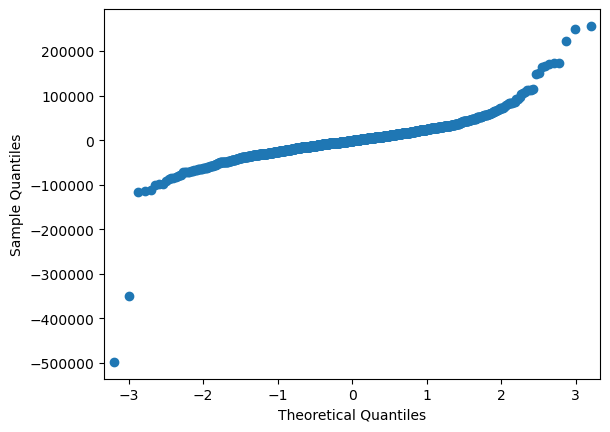

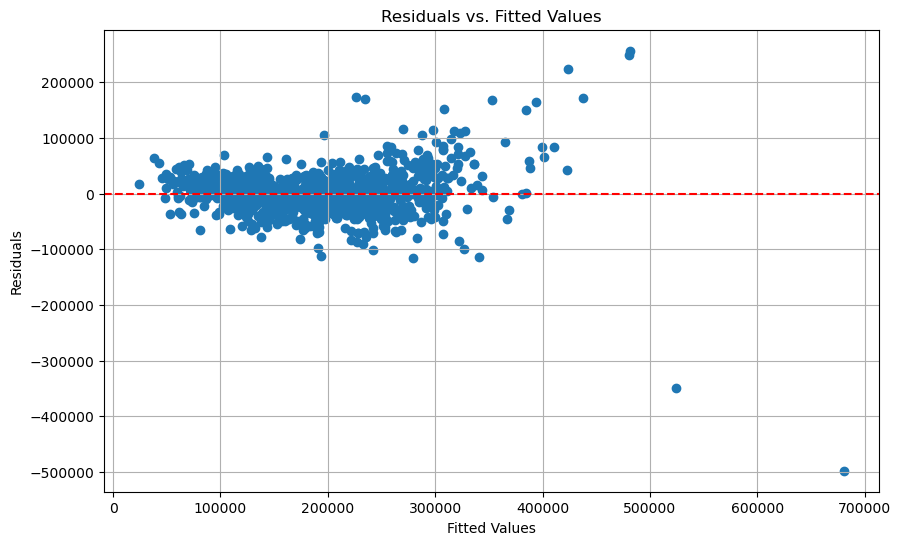

In [127]:
# check assumption
# Calculate residuals
residuals = stepreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals)
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(finreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [128]:
# Graphs shows violation of assumption
# log transformed regression
X = house_cleaned[['GarageCars', 'TotalBsmtSF', '2ndFlrSF','1stFlrSF','Foundation_PConc','Fireplaces','LotConfig_CulDSac','WoodDeckSF','YearRemodAdd_2009','YearRemodAdd_2010','BedroomAbvGr','YearBuilt_1900','ScreenPorch','BldgType_TwnhsE','FullBath','BldgType_Duplex','YearBuilt_1898','BldgType_Twnhs']]
X = sm.add_constant(X)
logy = np.log(y)
logreg = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     287.7
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:14:20   Log-Likelihood:                 381.58
No. Observations:                1460   AIC:                            -725.2
Df Residuals:                    1441   BIC:                            -624.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.0375      0.02

In [129]:
# log transformed regression final, drop BedroomAbvGr, BldgType_TwnhsE (P>0.05))
X = house_cleaned[['GarageCars', 'TotalBsmtSF', '2ndFlrSF','1stFlrSF','Foundation_PConc','Fireplaces','LotConfig_CulDSac','WoodDeckSF','YearRemodAdd_2009','YearRemodAdd_2010','YearBuilt_1900','ScreenPorch','FullBath','BldgType_Duplex','YearBuilt_1898','BldgType_Twnhs']]
X = sm.add_constant(X)
logy = np.log(y)
logreg = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     322.7
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:14:33   Log-Likelihood:                 379.18
No. Observations:                1460   AIC:                            -724.4
Df Residuals:                    1443   BIC:                            -634.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.0052      0.01

In [130]:
#check vif again
vifresfin = pd.DataFrame()
vifresfin["Variable"] = X.columns
vifresfin["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifresfin)

             Variable        VIF
0               const  15.565791
1          GarageCars   1.657688
2         TotalBsmtSF   3.425276
3            2ndFlrSF   1.705659
4            1stFlrSF   4.213170
5    Foundation_PConc   1.575785
6          Fireplaces   1.454273
7   LotConfig_CulDSac   1.020157
8          WoodDeckSF   1.134156
9   YearRemodAdd_2009   1.024688
10  YearRemodAdd_2010   1.011322
11     YearBuilt_1900   1.022976
12        ScreenPorch   1.068016
13           FullBath   2.065714
14    BldgType_Duplex   1.142426
15     YearBuilt_1898   1.004858
16     BldgType_Twnhs   1.050035


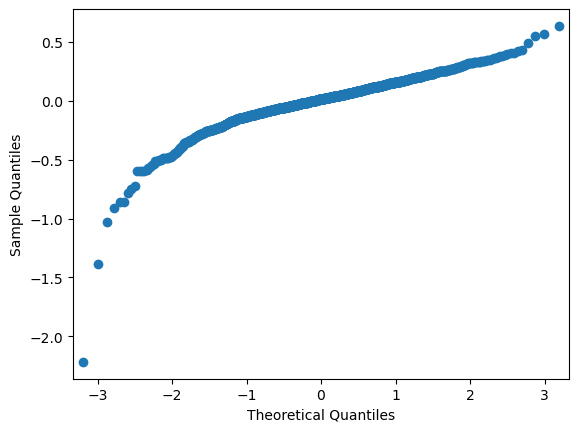

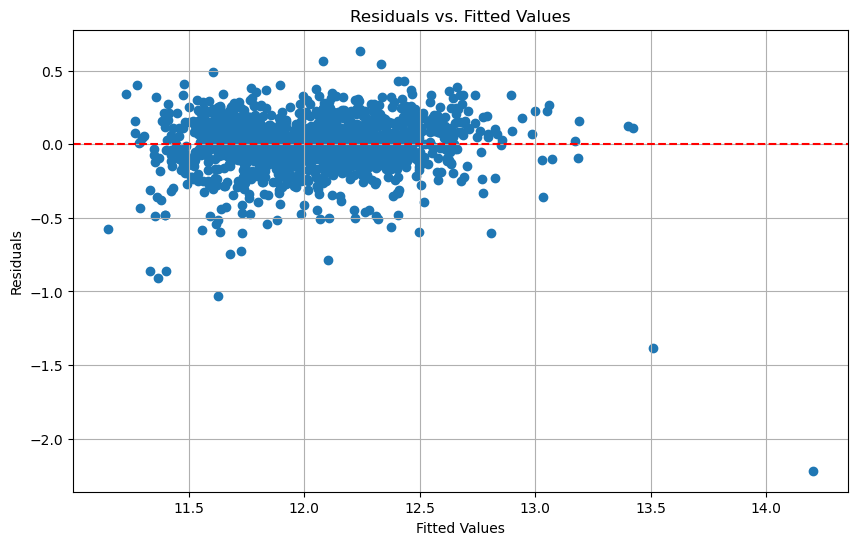

In [131]:
# All looks great
# check assumption

# Calculate residuals
residuals = logreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals)
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

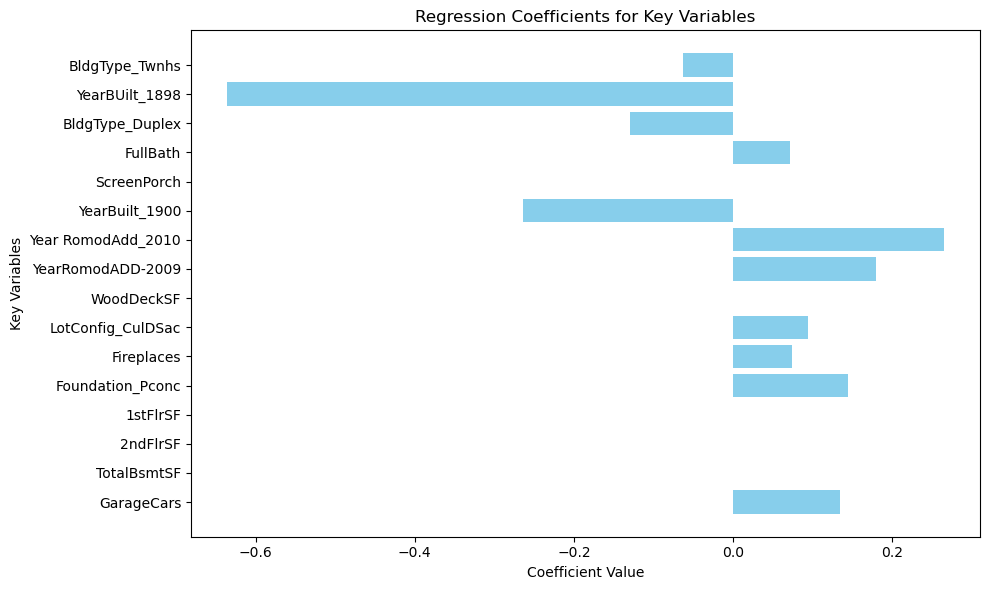

In [141]:
import matplotlib.pyplot as plt

# Variables and Coefficients
variables = [
    "GarageCars", "TotalBsmtSF", "2ndFlrSF", "1stFlrSF", "Foundation_Pconc", 
    "Fireplaces", "LotConfig_CulDSac", "WoodDeckSF", "YearRomodADD-2009", 
    "Year RomodAdd_2010", "YearBuilt_1900", "ScreenPorch", "FullBath", 
    "BldgType_Duplex", "YearBUilt_1898", "BldgType_Twnhs"
]

coefficients = [
    0.1343, 0.0002, 0.0002, 0.0002, 0.1439, 0.0746, 0.0946, 0.0002, 
    0.1792, 0.2652, -0.2639, 0.0004, 0.0713, -0.1294, -0.6361, -0.0635
]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(variables, coefficients, color='skyblue')

# Add labels and title
plt.xlabel('Coefficient Value')
plt.ylabel('Key Variables')
plt.title('Regression Coefficients for Key Variables')

# Show the plot
plt.tight_layout()
plt.show()

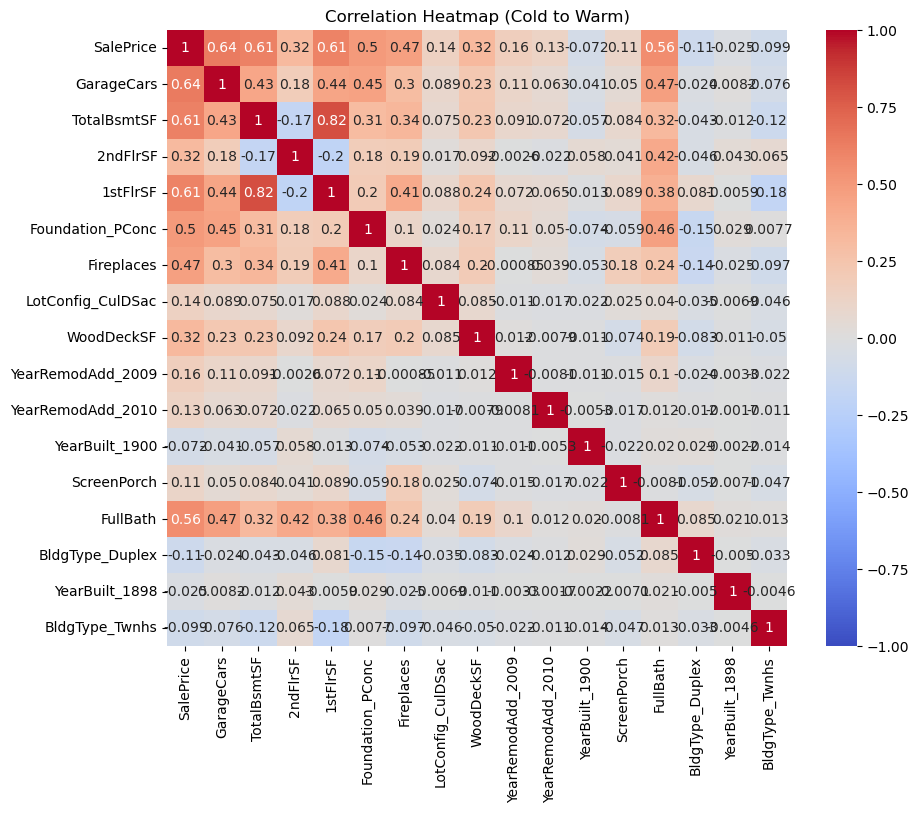

In [154]:
#check correlation

selected_columns = ['SalePrice', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF','1stFlrSF','Foundation_PConc','Fireplaces','LotConfig_CulDSac','WoodDeckSF','YearRemodAdd_2009','YearRemodAdd_2010','YearBuilt_1900','ScreenPorch','FullBath','BldgType_Duplex','YearBuilt_1898','BldgType_Twnhs']
house_cleaned_selected = house_cleaned[selected_columns]
corr_matrix = house_cleaned_selected.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Heatmap (Cold to Warm)')
plt.show()